## Fitting Data to ML Algorithms

In [1]:
import pathlib

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Read Data

We read the already preprocessed and split datasets

In [2]:
data_dir: pathlib.Path = pathlib.Path.cwd() / "datasets" / "processed"

In [3]:
train_df: pd.DataFrame = pd.read_parquet(data_dir / "train.parquet")
val_df: pd.DataFrame = pd.read_parquet(data_dir / "val.parquet")
test_df: pd.DataFrame = pd.read_parquet(data_dir / "test.parquet")

## Debugging & development

Uncomment this for faster computations.

In [4]:
train_df = train_df.sample(frac=0.5, random_state=0)
# val_df = val_df.sample(frac=0.1, random_state=0)
# test_df = test_df.sample(frac=0.2, random_state=0)

## Separate dependant and independant variables

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57793176 entries, 90502816 to 67164035
Data columns (total 24 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   DayOfWeek          uint8 
 1   DepDelay           uint16
 2   DepTime            uint16
 3   Origin             int64 
 4   DayofMonth         uint8 
 5   CRSDepTime         uint16
 6   ArrTime            uint16
 7   Diverted           bool  
 8   Airline            int64 
 9   Distance           uint16
 10  Cancelled          bool  
 11  ActualElapsedTime  int16 
 12  OriginCityName     int64 
 13  OriginState        int64 
 14  CRSElapsedTime     int16 
 15  DestCityName       int64 
 16  Month              uint8 
 17  ArrDelay           uint16
 18  DestAirport        int64 
 19  DestState          int64 
 20  Dest               int64 
 21  OriginAirport      int64 
 22  Year               uint16
 23  CRSArrTime         uint16
dtypes: bool(2), int16(2), int64(9), uint16(8), uint8(3)
memory usage: 5

In [6]:
irrelevant_columns = ['ActualElapsedTime', 'ArrTime', 'DepTime', 'DepDelay', 'ArrDelay', 'Origin', 'Dest', 'Cancelled', 'Diverted']

x_train, y_train = train_df.drop(irrelevant_columns, axis=1), train_df['ArrDelay']
x_val, y_val = val_df.drop(irrelevant_columns, axis=1), val_df['ArrDelay']
x_test, y_test = test_df.drop(irrelevant_columns, axis=1), test_df['ArrDelay']

<Axes: >

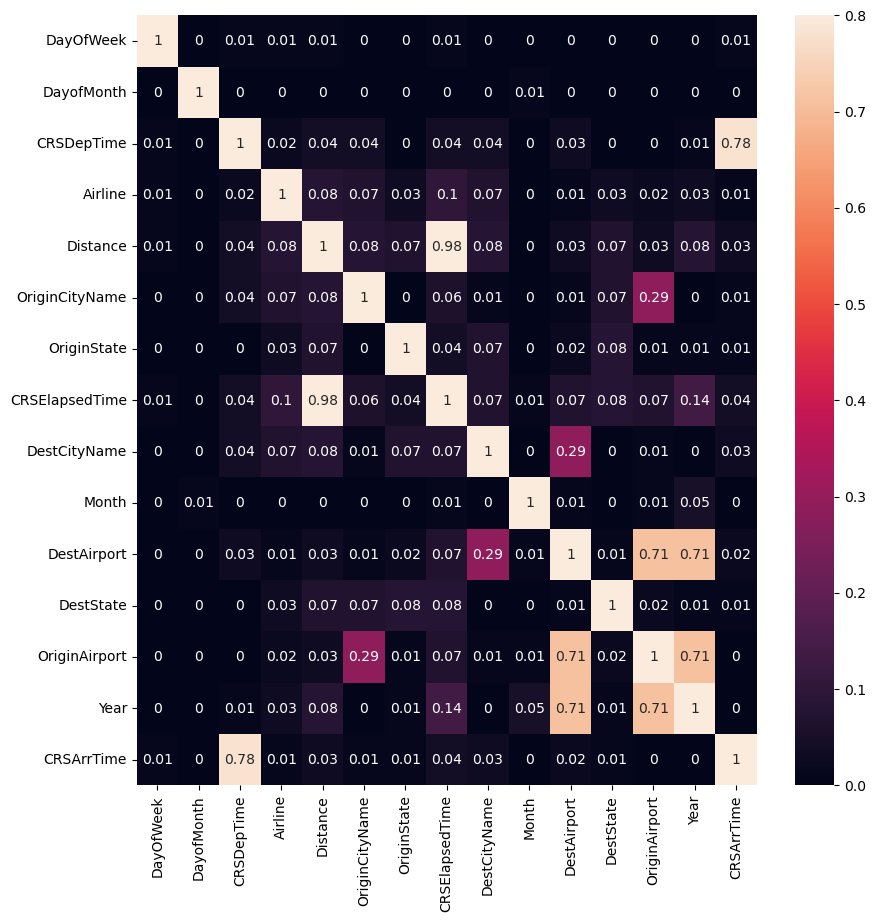

In [7]:
plt.figure(figsize=(10, 10))
sns.heatmap(x_train.corr().round(2).abs(), annot=True, vmax=0.8)

In [8]:
x_train.var()

DayOfWeek              3.973469
DayofMonth            77.201181
CRSDepTime        228113.084472
Airline              224.478055
Distance          312054.921230
OriginCityName     15720.089047
OriginState          250.568786
CRSElapsedTime      4762.866273
DestCityName       15607.524269
Month                 11.942147
DestAirport        30742.913847
DestState            250.521308
OriginAirport      31293.595306
Year                 103.326609
CRSArrTime        246046.301353
dtype: float64

In [9]:
x_train.drop(['CRSElapsedTime'], axis=1, inplace=True)
x_val.drop(['CRSElapsedTime'], axis=1, inplace=True)

In [10]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57793176 entries, 90502816 to 67164035
Data columns (total 14 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   DayOfWeek       uint8 
 1   DayofMonth      uint8 
 2   CRSDepTime      uint16
 3   Airline         int64 
 4   Distance        uint16
 5   OriginCityName  int64 
 6   OriginState     int64 
 7   DestCityName    int64 
 8   Month           uint8 
 9   DestAirport     int64 
 10  DestState       int64 
 11  OriginAirport   int64 
 12  Year            uint16
 13  CRSArrTime      uint16
dtypes: int64(7), uint16(4), uint8(3)
memory usage: 4.0 GB


<Axes: >

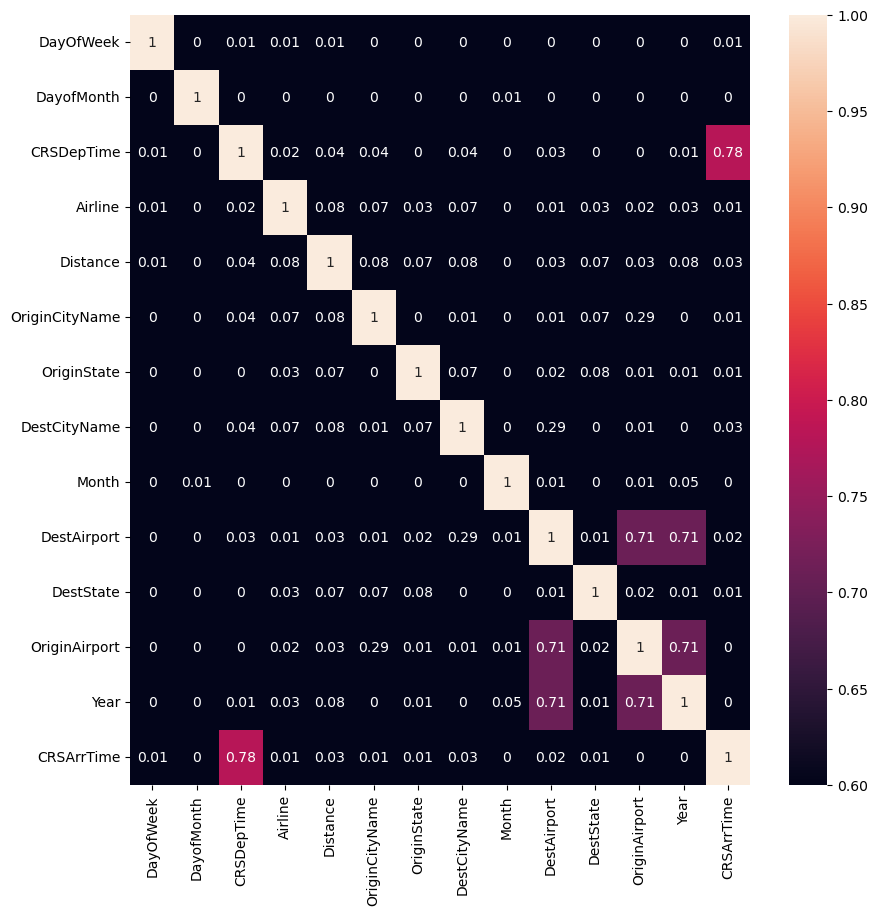

In [11]:
plt.figure(figsize=(10, 10))
sns.heatmap(x_train.corr().round(2).abs(), annot=True, vmin=0.6)

From the highly correlated features we drop the ones with the lowest variance.

## Fit forest

### Hyper parameter tuning

In [ ]:
random_grid = {'n_estimators': [5, 10, 25, 50, 100],
               'max_depth': [int(x) for x in np.linspace(5, 25, num = 5)],
               'min_samples_leaf': [1, 2]}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(),
                               param_distributions = random_grid,
                               n_iter = 10, cv = 3, random_state=42, n_jobs = -1)


In [ ]:
rf_random.fit(x_train.head(1000000), y_train.head(1000000))

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25],
                                        'min_samples_leaf': [1, 2],
                                        'n_estimators': [5, 10, 25, 50, 100]},
                   random_state=42)

In [ ]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=10, min_samples_leaf=2)

## Fitting the final

In [12]:
forest_regressor: RandomForestRegressor = RandomForestRegressor(random_state=42, n_jobs=-1, criterion='squared_error', max_depth=10, min_samples_leaf=2)

In [13]:
forest_regressor.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_jobs=-1,
                      random_state=42)

Save the regressor for further use during deployment.

In [14]:
from pickle import dump

dump(forest_regressor, open('models/random_forest_regressor_50.pkl', 'wb'))

## Evaluate on cross-validation data

In [15]:
pred_val = forest_regressor.predict(x_val)

In [16]:
# x_val_pred
y_val.reset_index(drop=True, inplace=True)

print(f'MSE: ', mean_squared_error(y_val, pred_val))
print(f'MAE: ', mean_absolute_error(y_val, pred_val))

MSE:  1001.4873982805265
MAE:  15.021303157317213


# NN

In [15]:
import tensorflow as tf

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=[len(x_train.columns)]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])


Metal device set to: Apple M2 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-03-28 15:37:35.199277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-28 15:37:35.199690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
# Doing something to make it work
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), metrics=['mean_absolute_error', 'mean_squared_error'])

Showing the summary of 

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                240       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=20480)

Epoch 1/10


2023-03-28 15:37:43.082323: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-28 15:37:43.390000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2822/2822 [==============================] - ETA: 0s - loss: 1850.4218 - mean_absolute_error: 15.7990 - mean_squared_error: 1850.4215

2023-03-28 15:38:12.311138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2822/2822 [==============================] - 31s 10ms/step - loss: 1850.4218 - mean_absolute_error: 15.7990 - mean_squared_error: 1850.4215 - val_loss: 1032.3997 - val_mean_absolute_error: 14.7333 - val_mean_squared_error: 1032.3997
Epoch 2/10
2822/2822 [==============================] - 28s 10ms/step - loss: 1043.8157 - mean_absolute_error: 15.3235 - mean_squared_error: 1043.8157 - val_loss: 1027.1829 - val_mean_absolute_error: 15.8375 - val_mean_squared_error: 1027.1829
Epoch 3/10
2822/2822 [==============================] - 28s 10ms/step - loss: 1041.1241 - mean_absolute_error: 15.5435 - mean_squared_error: 1041.1241 - val_loss: 1025.8264 - val_mean_absolute_error: 15.8075 - val_mean_squared_error: 1025.8264
Epoch 4/10
2822/2822 [==============================] - 28s 10ms/step - loss: 1040.6654 - mean_absolute_error: 15.5378 - mean_squared_error: 1040.6654 - val_loss: 1028.2363 - val_mean_absolute_error: 15.4360 - val_mean_squared_error: 1028.2363
Epoch 5/10
2822/2822 [=============

In [20]:
y_model = model.predict(x_val, batch_size=20480)

 73/706 [==>...........................] - ETA: 1s

2023-03-28 15:42:27.082050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


706/706 [==============================] - 1s 2ms/step


In [21]:
y_val

52267767     18
59174676      0
1616836       8
109373992     0
83707546      0
             ..
11393542      0
122590688    33
126355143     7
42360868      0
79680595      7
Name: ArrDelay, Length: 14448294, dtype: uint16

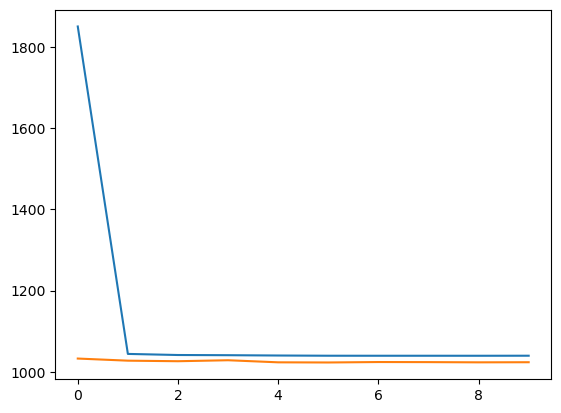

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [23]:
from pickle import dump

dump(model, open('models/nn_50.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://38a72790-ed8b-4c99-a4ea-d471b8636fc8/assets


### Evaluation on cross-validation set

In [24]:
print(f'MSE: ', mean_squared_error(y_val, y_model))
print(f'MAE: ', mean_absolute_error(y_val, y_model))

MSE:  1023.34393
MAE:  15.057689
